# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [18]:
import gc
gc.collect()

1525

In [19]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [20]:
import json
import wandb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # sklearn 내 confusion matrix 계산 함수
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈

In [21]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [22]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform
        self.image_paths = self._get_all_image_paths()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img_path = self.image_paths.get(name)
        if img_path is None:
            raise FileNotFoundError(f"Image {name} not found in {self.path}")
        img = np.array(Image.open(img_path))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

    def _get_all_image_paths(self):
        image_paths = {}
        for root, _, files in os.walk(self.path):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    image_paths[file] = os.path.join(root, file)
        return image_paths

In [23]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    # GPU 메모리 정리
    torch.cuda.empty_cache()
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [349]:
wandb.init(project = 'helloyoonjae-', name = 'fastcampus_cv11')

In [350]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
#data_path = '/data/ephemeral/home/datasets_fin/'

# model config
model_name = 'efficientnet_b3.ra2_in1k' #'vit_base_patch16_224' #'vit_base_patch16_224.augreg_in1k' ##'densenet121.ra_in1k'# #'resnet101' #'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 256 #224 #256
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 16
num_workers = 16

In [352]:
# Hyper-parameters를 WandB에 로깅
wandb.config = {
    "learning_rate": LR,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "model_name": model_name,
    "img_size": img_size,
    "num_workers": num_workers
}

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [353]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# valid split

In [41]:
# Read the full dataset
full_dataset_df = pd.read_csv("/data/ephemeral/home/datasets_fin/combined_train.csv")

# Split the dataset into training and validation
train_df, valid_df = train_test_split(full_dataset_df, test_size=0.2, random_state=SEED)

# Save the split data (optional, for consistency in multiple runs)
train_df.to_csv("/data/ephemeral/home/datasets_fin/train_split.csv", index=False)
valid_df.to_csv("/data/ephemeral/home/datasets_fin/valid_split.csv", index=False)

In [354]:
# Dataset 정의
trn_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/combined_train.csv",
    "/data/ephemeral/home/datasets_fin/combined_train",
    transform=trn_transform
)
train_split_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/train_split.csv",
    "/data/ephemeral/home/datasets_fin/combined_train",
    transform=trn_transform  # Or a specific validation transform if different
)
val_split_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/valid_split.csv",
    "/data/ephemeral/home/datasets_fin/combined_train",
    transform=trn_transform  # Or a specific validation transform if different
)
tst_dataset = ImageDataset(
    "/data/ephemeral/home/datasets_fin/sample_submission.csv",
    "/data/ephemeral/home/datasets_fin/test/",
    transform=tst_transform
)
print(len(trn_dataset),len(train_split_dataset),len(val_split_dataset), len(tst_dataset))

15700 12560 3140 3140


In [355]:
# GPU 메모리 정리
torch.cuda.empty_cache()


# kfold

In [141]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

# K-Fold 교차 검증
fold = 0
for train_idx, val_idx in kf.split(trn_dataset):
    fold += 1
    print(f"Fold {fold}")

    train_subset = Subset(trn_dataset, train_idx)
    val_subset = Subset(trn_dataset, val_idx)

    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # 모델 로드
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=17
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LR)

    # 모델 학습
    for epoch in range(EPOCHS):
        ret = train_one_epoch(train_loader, model, optimizer, loss_fn, device)
        ret['epoch'] = epoch

        log = ""
        for k, v in ret.items():
            log += f"{k}: {v:.4f}\n"
        print(log)

        # 검증 세트에서 모델 평가
        model.eval()
        val_loss = 0
        preds_list = []
        targets_list = []

        with torch.no_grad():
            for image, targets in val_loader:
                image = image.to(device)
                targets = targets.to(device)

                preds = model(image)
                loss = loss_fn(preds, targets)

                val_loss += loss.item()
                preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
                targets_list.extend(targets.detach().cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(targets_list, preds_list)
        val_f1 = f1_score(targets_list, preds_list, average='macro')
        print(f"Fold {fold}, Epoch {epoch+1}/{EPOCHS}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")


Fold 1


Loss: 0.0064: 100%|██████████| 393/393 [01:59<00:00,  3.30it/s]


train_loss: 0.3318
train_acc: 0.8865
train_f1: 0.8786
epoch: 0.0000

Fold 1, Epoch 1/30, Val Loss: 0.0914, Val Acc: 0.9662, Val F1: 0.9649


Loss: 0.4254: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.1117
train_acc: 0.9611
train_f1: 0.9592
epoch: 1.0000

Fold 1, Epoch 2/30, Val Loss: 0.1948, Val Acc: 0.9545, Val F1: 0.9524


Loss: 0.0603: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0826
train_acc: 0.9732
train_f1: 0.9718
epoch: 2.0000

Fold 1, Epoch 3/30, Val Loss: 0.0362, Val Acc: 0.9889, Val F1: 0.9893


Loss: 0.1748: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0422
train_acc: 0.9869
train_f1: 0.9867
epoch: 3.0000

Fold 1, Epoch 4/30, Val Loss: 0.0405, Val Acc: 0.9876, Val F1: 0.9878


Loss: 0.0017: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0297
train_acc: 0.9907
train_f1: 0.9896
epoch: 4.0000

Fold 1, Epoch 5/30, Val Loss: 0.0762, Val Acc: 0.9755, Val F1: 0.9747


Loss: 0.1256: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0621
train_acc: 0.9805
train_f1: 0.9799
epoch: 5.0000

Fold 1, Epoch 6/30, Val Loss: 0.0942, Val Acc: 0.9732, Val F1: 0.9728


Loss: 0.0419: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0543
train_acc: 0.9835
train_f1: 0.9820
epoch: 6.0000

Fold 1, Epoch 7/30, Val Loss: 0.0497, Val Acc: 0.9818, Val F1: 0.9808


Loss: 0.0033: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0292
train_acc: 0.9899
train_f1: 0.9891
epoch: 7.0000

Fold 1, Epoch 8/30, Val Loss: 0.0481, Val Acc: 0.9822, Val F1: 0.9812


Loss: 0.0029: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0347
train_acc: 0.9900
train_f1: 0.9891
epoch: 8.0000

Fold 1, Epoch 9/30, Val Loss: 0.6537, Val Acc: 0.9220, Val F1: 0.9225


Loss: 0.1561: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0454
train_acc: 0.9874
train_f1: 0.9865
epoch: 9.0000

Fold 1, Epoch 10/30, Val Loss: 0.0377, Val Acc: 0.9873, Val F1: 0.9870


Loss: 0.0766: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0121
train_acc: 0.9970
train_f1: 0.9969
epoch: 10.0000

Fold 1, Epoch 11/30, Val Loss: 0.0304, Val Acc: 0.9924, Val F1: 0.9921


Loss: 0.0072: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0068
train_acc: 0.9983
train_f1: 0.9980
epoch: 11.0000

Fold 1, Epoch 12/30, Val Loss: 0.0302, Val Acc: 0.9908, Val F1: 0.9894


Loss: 0.0081: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0266
train_acc: 0.9919
train_f1: 0.9916
epoch: 12.0000

Fold 1, Epoch 13/30, Val Loss: 0.0689, Val Acc: 0.9745, Val F1: 0.9733


Loss: 0.0574: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0557
train_acc: 0.9829
train_f1: 0.9818
epoch: 13.0000

Fold 1, Epoch 14/30, Val Loss: 0.0344, Val Acc: 0.9889, Val F1: 0.9892


Loss: 0.0117: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0219
train_acc: 0.9924
train_f1: 0.9922
epoch: 14.0000

Fold 1, Epoch 15/30, Val Loss: 0.0471, Val Acc: 0.9847, Val F1: 0.9843


Loss: 0.0025: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0112
train_acc: 0.9966
train_f1: 0.9964
epoch: 15.0000

Fold 1, Epoch 16/30, Val Loss: 0.0438, Val Acc: 0.9876, Val F1: 0.9861


Loss: 0.0055: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0154
train_acc: 0.9946
train_f1: 0.9941
epoch: 16.0000

Fold 1, Epoch 17/30, Val Loss: 0.0812, Val Acc: 0.9780, Val F1: 0.9782


Loss: 0.0412: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0323
train_acc: 0.9902
train_f1: 0.9895
epoch: 17.0000

Fold 1, Epoch 18/30, Val Loss: 0.0617, Val Acc: 0.9847, Val F1: 0.9847


Loss: 0.0043: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0155
train_acc: 0.9950
train_f1: 0.9949
epoch: 18.0000

Fold 1, Epoch 19/30, Val Loss: 0.1077, Val Acc: 0.9841, Val F1: 0.9835


Loss: 0.0070: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0194
train_acc: 0.9951
train_f1: 0.9947
epoch: 19.0000

Fold 1, Epoch 20/30, Val Loss: 0.2351, Val Acc: 0.9564, Val F1: 0.9553


Loss: 0.0011: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0451
train_acc: 0.9873
train_f1: 0.9864
epoch: 20.0000

Fold 1, Epoch 21/30, Val Loss: 0.0504, Val Acc: 0.9854, Val F1: 0.9849


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0151
train_acc: 0.9944
train_f1: 0.9941
epoch: 21.0000

Fold 1, Epoch 22/30, Val Loss: 0.0279, Val Acc: 0.9920, Val F1: 0.9917


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0051
train_acc: 0.9983
train_f1: 0.9981
epoch: 22.0000

Fold 1, Epoch 23/30, Val Loss: 0.0318, Val Acc: 0.9917, Val F1: 0.9916


Loss: 0.0662: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0023
train_acc: 0.9991
train_f1: 0.9990
epoch: 23.0000

Fold 1, Epoch 24/30, Val Loss: 0.0341, Val Acc: 0.9927, Val F1: 0.9924


Loss: 0.0013: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0308
train_acc: 0.9902
train_f1: 0.9894
epoch: 24.0000

Fold 1, Epoch 25/30, Val Loss: 0.0327, Val Acc: 0.9908, Val F1: 0.9904


Loss: 0.0008: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0235
train_acc: 0.9931
train_f1: 0.9926
epoch: 25.0000

Fold 1, Epoch 26/30, Val Loss: 0.0227, Val Acc: 0.9930, Val F1: 0.9927


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0113
train_acc: 0.9955
train_f1: 0.9948
epoch: 26.0000

Fold 1, Epoch 27/30, Val Loss: 0.0173, Val Acc: 0.9952, Val F1: 0.9954


Loss: 0.0006: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0047
train_acc: 0.9982
train_f1: 0.9981
epoch: 27.0000

Fold 1, Epoch 28/30, Val Loss: 0.0230, Val Acc: 0.9933, Val F1: 0.9930


Loss: 0.0033: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0172
train_acc: 0.9951
train_f1: 0.9946
epoch: 28.0000

Fold 1, Epoch 29/30, Val Loss: 0.0431, Val Acc: 0.9889, Val F1: 0.9886


Loss: 0.0564: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0183
train_acc: 0.9936
train_f1: 0.9934
epoch: 29.0000

Fold 1, Epoch 30/30, Val Loss: 0.0581, Val Acc: 0.9844, Val F1: 0.9837
Fold 2


Loss: 0.7800: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.3497
train_acc: 0.8846
train_f1: 0.8763
epoch: 0.0000

Fold 2, Epoch 1/30, Val Loss: 0.1689, Val Acc: 0.9424, Val F1: 0.9394


Loss: 0.0655: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.1184
train_acc: 0.9592
train_f1: 0.9568
epoch: 1.0000

Fold 2, Epoch 2/30, Val Loss: 0.0882, Val Acc: 0.9694, Val F1: 0.9679


Loss: 0.0044: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0670
train_acc: 0.9779
train_f1: 0.9771
epoch: 2.0000

Fold 2, Epoch 3/30, Val Loss: 0.0645, Val Acc: 0.9780, Val F1: 0.9766


Loss: 0.0058: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0707
train_acc: 0.9773
train_f1: 0.9760
epoch: 3.0000

Fold 2, Epoch 4/30, Val Loss: 0.0525, Val Acc: 0.9844, Val F1: 0.9835


Loss: 0.0018: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0551
train_acc: 0.9822
train_f1: 0.9812
epoch: 4.0000

Fold 2, Epoch 5/30, Val Loss: 0.0545, Val Acc: 0.9844, Val F1: 0.9824


Loss: 0.2376: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0280
train_acc: 0.9912
train_f1: 0.9908
epoch: 5.0000

Fold 2, Epoch 6/30, Val Loss: 0.1770, Val Acc: 0.9796, Val F1: 0.9784


Loss: 0.0768: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0458
train_acc: 0.9864
train_f1: 0.9848
epoch: 6.0000

Fold 2, Epoch 7/30, Val Loss: 0.0918, Val Acc: 0.9799, Val F1: 0.9787


Loss: 0.0688: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0396
train_acc: 0.9889
train_f1: 0.9890
epoch: 7.0000

Fold 2, Epoch 8/30, Val Loss: 0.0656, Val Acc: 0.9812, Val F1: 0.9802


Loss: 0.0068: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0339
train_acc: 0.9897
train_f1: 0.9895
epoch: 8.0000

Fold 2, Epoch 9/30, Val Loss: 0.1137, Val Acc: 0.9697, Val F1: 0.9644


Loss: 0.0005: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0358
train_acc: 0.9890
train_f1: 0.9887
epoch: 9.0000

Fold 2, Epoch 10/30, Val Loss: 0.1634, Val Acc: 0.9777, Val F1: 0.9762


Loss: 0.0014: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0232
train_acc: 0.9928
train_f1: 0.9925
epoch: 10.0000

Fold 2, Epoch 11/30, Val Loss: 0.0976, Val Acc: 0.9806, Val F1: 0.9784


Loss: 0.0029: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0240
train_acc: 0.9922
train_f1: 0.9917
epoch: 11.0000

Fold 2, Epoch 12/30, Val Loss: 0.0916, Val Acc: 0.9748, Val F1: 0.9732


Loss: 0.0076: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0204
train_acc: 0.9936
train_f1: 0.9933
epoch: 12.0000

Fold 2, Epoch 13/30, Val Loss: 0.0305, Val Acc: 0.9927, Val F1: 0.9918


Loss: 0.0698: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0390
train_acc: 0.9879
train_f1: 0.9873
epoch: 13.0000

Fold 2, Epoch 14/30, Val Loss: 0.0933, Val Acc: 0.9768, Val F1: 0.9752


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0204
train_acc: 0.9928
train_f1: 0.9922
epoch: 14.0000

Fold 2, Epoch 15/30, Val Loss: 0.0749, Val Acc: 0.9847, Val F1: 0.9845


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0257
train_acc: 0.9920
train_f1: 0.9915
epoch: 15.0000

Fold 2, Epoch 16/30, Val Loss: 0.1005, Val Acc: 0.9796, Val F1: 0.9773


Loss: 0.0089: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0225
train_acc: 0.9930
train_f1: 0.9925
epoch: 16.0000

Fold 2, Epoch 17/30, Val Loss: 0.0497, Val Acc: 0.9892, Val F1: 0.9885


Loss: 0.0240: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0229
train_acc: 0.9943
train_f1: 0.9937
epoch: 17.0000

Fold 2, Epoch 18/30, Val Loss: 0.0521, Val Acc: 0.9857, Val F1: 0.9840


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0222
train_acc: 0.9943
train_f1: 0.9941
epoch: 18.0000

Fold 2, Epoch 19/30, Val Loss: 0.0317, Val Acc: 0.9904, Val F1: 0.9894


Loss: 0.0040: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0082
train_acc: 0.9974
train_f1: 0.9974
epoch: 19.0000

Fold 2, Epoch 20/30, Val Loss: 0.0559, Val Acc: 0.9876, Val F1: 0.9869


Loss: 0.0007: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0303
train_acc: 0.9898
train_f1: 0.9889
epoch: 20.0000

Fold 2, Epoch 21/30, Val Loss: 0.0365, Val Acc: 0.9901, Val F1: 0.9896


Loss: 0.1129: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0144
train_acc: 0.9954
train_f1: 0.9954
epoch: 21.0000

Fold 2, Epoch 22/30, Val Loss: 0.0316, Val Acc: 0.9873, Val F1: 0.9868


Loss: 0.0049: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0109
train_acc: 0.9968
train_f1: 0.9965
epoch: 22.0000

Fold 2, Epoch 23/30, Val Loss: 0.0534, Val Acc: 0.9895, Val F1: 0.9881


Loss: 0.0325: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0172
train_acc: 0.9951
train_f1: 0.9950
epoch: 23.0000

Fold 2, Epoch 24/30, Val Loss: 0.1735, Val Acc: 0.9634, Val F1: 0.9608


Loss: 0.0006: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0383
train_acc: 0.9877
train_f1: 0.9872
epoch: 24.0000

Fold 2, Epoch 25/30, Val Loss: 0.0297, Val Acc: 0.9914, Val F1: 0.9914


Loss: 0.0025: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0029
train_acc: 0.9990
train_f1: 0.9990
epoch: 25.0000

Fold 2, Epoch 26/30, Val Loss: 0.0223, Val Acc: 0.9946, Val F1: 0.9939


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0011
train_acc: 0.9996
train_f1: 0.9996
epoch: 26.0000

Fold 2, Epoch 27/30, Val Loss: 0.0201, Val Acc: 0.9949, Val F1: 0.9946


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0004
train_acc: 1.0000
train_f1: 1.0000
epoch: 27.0000

Fold 2, Epoch 28/30, Val Loss: 0.0192, Val Acc: 0.9955, Val F1: 0.9951


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0001
train_acc: 1.0000
train_f1: 1.0000
epoch: 28.0000

Fold 2, Epoch 29/30, Val Loss: 0.0314, Val Acc: 0.9962, Val F1: 0.9958


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0000
train_acc: 1.0000
train_f1: 1.0000
epoch: 29.0000

Fold 2, Epoch 30/30, Val Loss: 0.0175, Val Acc: 0.9968, Val F1: 0.9966
Fold 3


Loss: 0.0488: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.3436
train_acc: 0.8857
train_f1: 0.8790
epoch: 0.0000

Fold 3, Epoch 1/30, Val Loss: 0.1791, Val Acc: 0.9420, Val F1: 0.9364


Loss: 0.0330: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.1072
train_acc: 0.9659
train_f1: 0.9641
epoch: 1.0000

Fold 3, Epoch 2/30, Val Loss: 0.1767, Val Acc: 0.9513, Val F1: 0.9446


Loss: 0.0498: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0730
train_acc: 0.9749
train_f1: 0.9737
epoch: 2.0000

Fold 3, Epoch 3/30, Val Loss: 0.0589, Val Acc: 0.9777, Val F1: 0.9762


Loss: 0.0627: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0560
train_acc: 0.9814
train_f1: 0.9809
epoch: 3.0000

Fold 3, Epoch 4/30, Val Loss: 0.0716, Val Acc: 0.9777, Val F1: 0.9752


Loss: 0.0047: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0738
train_acc: 0.9779
train_f1: 0.9771
epoch: 4.0000

Fold 3, Epoch 5/30, Val Loss: 0.0657, Val Acc: 0.9774, Val F1: 0.9754


Loss: 0.0108: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0260
train_acc: 0.9912
train_f1: 0.9912
epoch: 5.0000

Fold 3, Epoch 6/30, Val Loss: 0.0979, Val Acc: 0.9729, Val F1: 0.9712


Loss: 0.0691: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0190
train_acc: 0.9946
train_f1: 0.9944
epoch: 6.0000

Fold 3, Epoch 7/30, Val Loss: 0.0279, Val Acc: 0.9914, Val F1: 0.9911


Loss: 0.0010: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0459
train_acc: 0.9860
train_f1: 0.9851
epoch: 7.0000

Fold 3, Epoch 8/30, Val Loss: 0.0533, Val Acc: 0.9818, Val F1: 0.9802


Loss: 0.0826: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0476
train_acc: 0.9858
train_f1: 0.9852
epoch: 8.0000

Fold 3, Epoch 9/30, Val Loss: 0.0885, Val Acc: 0.9713, Val F1: 0.9685


Loss: 0.0072: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0474
train_acc: 0.9846
train_f1: 0.9835
epoch: 9.0000

Fold 3, Epoch 10/30, Val Loss: 0.0488, Val Acc: 0.9863, Val F1: 0.9858


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0205
train_acc: 0.9937
train_f1: 0.9935
epoch: 10.0000

Fold 3, Epoch 11/30, Val Loss: 0.0295, Val Acc: 0.9949, Val F1: 0.9947


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0036
train_acc: 0.9991
train_f1: 0.9991
epoch: 11.0000

Fold 3, Epoch 12/30, Val Loss: 0.0210, Val Acc: 0.9936, Val F1: 0.9934


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0354
train_acc: 0.9884
train_f1: 0.9876
epoch: 12.0000

Fold 3, Epoch 13/30, Val Loss: 0.0448, Val Acc: 0.9850, Val F1: 0.9846


Loss: 0.0026: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0420
train_acc: 0.9880
train_f1: 0.9873
epoch: 13.0000

Fold 3, Epoch 14/30, Val Loss: 0.0673, Val Acc: 0.9787, Val F1: 0.9748


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0173
train_acc: 0.9939
train_f1: 0.9936
epoch: 14.0000

Fold 3, Epoch 15/30, Val Loss: 0.0141, Val Acc: 0.9949, Val F1: 0.9945


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0044
train_acc: 0.9986
train_f1: 0.9984
epoch: 15.0000

Fold 3, Epoch 16/30, Val Loss: 0.0158, Val Acc: 0.9933, Val F1: 0.9927


Loss: 0.0095: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0300
train_acc: 0.9910
train_f1: 0.9905
epoch: 16.0000

Fold 3, Epoch 17/30, Val Loss: 0.1242, Val Acc: 0.9697, Val F1: 0.9630


Loss: 1.6676: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0419
train_acc: 0.9887
train_f1: 0.9881
epoch: 17.0000

Fold 3, Epoch 18/30, Val Loss: 0.0505, Val Acc: 0.9831, Val F1: 0.9830


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0240
train_acc: 0.9926
train_f1: 0.9921
epoch: 18.0000

Fold 3, Epoch 19/30, Val Loss: 0.0207, Val Acc: 0.9930, Val F1: 0.9922


Loss: 0.0210: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0064
train_acc: 0.9979
train_f1: 0.9978
epoch: 19.0000

Fold 3, Epoch 20/30, Val Loss: 0.0463, Val Acc: 0.9876, Val F1: 0.9855


Loss: 0.0033: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0328
train_acc: 0.9906
train_f1: 0.9899
epoch: 20.0000

Fold 3, Epoch 21/30, Val Loss: 0.0275, Val Acc: 0.9914, Val F1: 0.9905


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0071
train_acc: 0.9976
train_f1: 0.9972
epoch: 21.0000

Fold 3, Epoch 22/30, Val Loss: 0.0148, Val Acc: 0.9968, Val F1: 0.9967


Loss: 0.0068: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0021
train_acc: 0.9993
train_f1: 0.9993
epoch: 22.0000

Fold 3, Epoch 23/30, Val Loss: 0.0093, Val Acc: 0.9981, Val F1: 0.9979


Loss: 0.0004: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0047
train_acc: 0.9985
train_f1: 0.9983
epoch: 23.0000

Fold 3, Epoch 24/30, Val Loss: 0.1044, Val Acc: 0.9780, Val F1: 0.9750


Loss: 0.0116: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0378
train_acc: 0.9886
train_f1: 0.9884
epoch: 24.0000

Fold 3, Epoch 25/30, Val Loss: 0.0324, Val Acc: 0.9885, Val F1: 0.9872


Loss: 0.0009: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0270
train_acc: 0.9911
train_f1: 0.9904
epoch: 25.0000

Fold 3, Epoch 26/30, Val Loss: 0.0329, Val Acc: 0.9904, Val F1: 0.9902


Loss: 0.0036: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0087
train_acc: 0.9974
train_f1: 0.9973
epoch: 26.0000

Fold 3, Epoch 27/30, Val Loss: 0.0129, Val Acc: 0.9962, Val F1: 0.9962


Loss: 0.0004: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0019
train_acc: 0.9997
train_f1: 0.9997
epoch: 27.0000

Fold 3, Epoch 28/30, Val Loss: 0.0119, Val Acc: 0.9955, Val F1: 0.9951


Loss: 0.0017: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0203
train_acc: 0.9949
train_f1: 0.9943
epoch: 28.0000

Fold 3, Epoch 29/30, Val Loss: 0.1130, Val Acc: 0.9742, Val F1: 0.9731


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0269
train_acc: 0.9925
train_f1: 0.9923
epoch: 29.0000

Fold 3, Epoch 30/30, Val Loss: 0.0195, Val Acc: 0.9943, Val F1: 0.9941
Fold 4


Loss: 0.0619: 100%|██████████| 393/393 [01:57<00:00,  3.34it/s]


train_loss: 0.3441
train_acc: 0.8843
train_f1: 0.8745
epoch: 0.0000

Fold 4, Epoch 1/30, Val Loss: 0.1843, Val Acc: 0.9328, Val F1: 0.9319


Loss: 0.2493: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0940
train_acc: 0.9678
train_f1: 0.9660
epoch: 1.0000

Fold 4, Epoch 2/30, Val Loss: 0.1166, Val Acc: 0.9605, Val F1: 0.9602


Loss: 0.0579: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0868
train_acc: 0.9701
train_f1: 0.9686
epoch: 2.0000

Fold 4, Epoch 3/30, Val Loss: 0.0560, Val Acc: 0.9793, Val F1: 0.9791


Loss: 0.0005: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0398
train_acc: 0.9879
train_f1: 0.9869
epoch: 3.0000

Fold 4, Epoch 4/30, Val Loss: 0.1020, Val Acc: 0.9707, Val F1: 0.9699


Loss: 0.1589: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0559
train_acc: 0.9819
train_f1: 0.9807
epoch: 4.0000

Fold 4, Epoch 5/30, Val Loss: 0.1081, Val Acc: 0.9736, Val F1: 0.9721


Loss: 0.0011: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0440
train_acc: 0.9857
train_f1: 0.9854
epoch: 5.0000

Fold 4, Epoch 6/30, Val Loss: 0.0630, Val Acc: 0.9761, Val F1: 0.9741


Loss: 0.0006: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0382
train_acc: 0.9876
train_f1: 0.9870
epoch: 6.0000

Fold 4, Epoch 7/30, Val Loss: 0.0842, Val Acc: 0.9768, Val F1: 0.9766


Loss: 0.1673: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0435
train_acc: 0.9877
train_f1: 0.9872
epoch: 7.0000

Fold 4, Epoch 8/30, Val Loss: 0.1313, Val Acc: 0.9640, Val F1: 0.9636


Loss: 0.0007: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0280
train_acc: 0.9912
train_f1: 0.9901
epoch: 8.0000

Fold 4, Epoch 9/30, Val Loss: 0.0854, Val Acc: 0.9748, Val F1: 0.9729


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0406
train_acc: 0.9877
train_f1: 0.9868
epoch: 9.0000

Fold 4, Epoch 10/30, Val Loss: 0.0376, Val Acc: 0.9876, Val F1: 0.9877


Loss: 0.0004: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0191
train_acc: 0.9946
train_f1: 0.9942
epoch: 10.0000

Fold 4, Epoch 11/30, Val Loss: 0.0396, Val Acc: 0.9895, Val F1: 0.9891


Loss: 0.1166: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0078
train_acc: 0.9977
train_f1: 0.9972
epoch: 11.0000

Fold 4, Epoch 12/30, Val Loss: 0.0336, Val Acc: 0.9914, Val F1: 0.9911


Loss: 0.0099: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0565
train_acc: 0.9829
train_f1: 0.9817
epoch: 12.0000

Fold 4, Epoch 13/30, Val Loss: 0.0641, Val Acc: 0.9809, Val F1: 0.9798


Loss: 0.0017: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0218
train_acc: 0.9936
train_f1: 0.9934
epoch: 13.0000

Fold 4, Epoch 14/30, Val Loss: 0.0401, Val Acc: 0.9892, Val F1: 0.9889


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0180
train_acc: 0.9947
train_f1: 0.9944
epoch: 14.0000

Fold 4, Epoch 15/30, Val Loss: 0.0464, Val Acc: 0.9892, Val F1: 0.9888


Loss: 0.0915: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0073
train_acc: 0.9979
train_f1: 0.9979
epoch: 15.0000

Fold 4, Epoch 16/30, Val Loss: 0.0490, Val Acc: 0.9898, Val F1: 0.9899


Loss: 0.0466: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0473
train_acc: 0.9869
train_f1: 0.9853
epoch: 16.0000

Fold 4, Epoch 17/30, Val Loss: 0.0981, Val Acc: 0.9694, Val F1: 0.9674


Loss: 0.0088: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0324
train_acc: 0.9907
train_f1: 0.9898
epoch: 17.0000

Fold 4, Epoch 18/30, Val Loss: 0.0898, Val Acc: 0.9815, Val F1: 0.9805


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0231
train_acc: 0.9931
train_f1: 0.9929
epoch: 18.0000

Fold 4, Epoch 19/30, Val Loss: 0.0683, Val Acc: 0.9850, Val F1: 0.9847


Loss: 0.0048: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0118
train_acc: 0.9964
train_f1: 0.9965
epoch: 19.0000

Fold 4, Epoch 20/30, Val Loss: 0.0394, Val Acc: 0.9892, Val F1: 0.9892


Loss: 0.0091: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0122
train_acc: 0.9966
train_f1: 0.9964
epoch: 20.0000

Fold 4, Epoch 21/30, Val Loss: 0.0950, Val Acc: 0.9793, Val F1: 0.9795


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0152
train_acc: 0.9957
train_f1: 0.9955
epoch: 21.0000

Fold 4, Epoch 22/30, Val Loss: 0.2241, Val Acc: 0.9882, Val F1: 0.9879


Loss: 0.0006: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0228
train_acc: 0.9930
train_f1: 0.9925
epoch: 22.0000

Fold 4, Epoch 23/30, Val Loss: 0.5542, Val Acc: 0.9717, Val F1: 0.9725


Loss: 0.0158: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0346
train_acc: 0.9924
train_f1: 0.9924
epoch: 23.0000

Fold 4, Epoch 24/30, Val Loss: 0.0308, Val Acc: 0.9879, Val F1: 0.9879


Loss: 0.0003: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0080
train_acc: 0.9973
train_f1: 0.9970
epoch: 24.0000

Fold 4, Epoch 25/30, Val Loss: 0.0338, Val Acc: 0.9914, Val F1: 0.9910


Loss: 0.1365: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0097
train_acc: 0.9971
train_f1: 0.9970
epoch: 25.0000

Fold 4, Epoch 26/30, Val Loss: 0.0757, Val Acc: 0.9838, Val F1: 0.9828


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0215
train_acc: 0.9943
train_f1: 0.9936
epoch: 26.0000

Fold 4, Epoch 27/30, Val Loss: 0.0917, Val Acc: 0.9844, Val F1: 0.9844


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0114
train_acc: 0.9955
train_f1: 0.9950
epoch: 27.0000

Fold 4, Epoch 28/30, Val Loss: 0.0365, Val Acc: 0.9898, Val F1: 0.9891


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0204
train_acc: 0.9939
train_f1: 0.9936
epoch: 28.0000

Fold 4, Epoch 29/30, Val Loss: 0.0542, Val Acc: 0.9869, Val F1: 0.9867


Loss: 0.0018: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0086
train_acc: 0.9970
train_f1: 0.9969
epoch: 29.0000

Fold 4, Epoch 30/30, Val Loss: 0.0516, Val Acc: 0.9889, Val F1: 0.9889
Fold 5


Loss: 0.2149: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.3422
train_acc: 0.8827
train_f1: 0.8758
epoch: 0.0000

Fold 5, Epoch 1/30, Val Loss: 0.1665, Val Acc: 0.9404, Val F1: 0.9366


Loss: 0.1898: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.1019
train_acc: 0.9649
train_f1: 0.9634
epoch: 1.0000

Fold 5, Epoch 2/30, Val Loss: 0.1043, Val Acc: 0.9669, Val F1: 0.9644


Loss: 0.1201: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0821
train_acc: 0.9711
train_f1: 0.9695
epoch: 2.0000

Fold 5, Epoch 3/30, Val Loss: 0.0834, Val Acc: 0.9701, Val F1: 0.9674


Loss: 0.0657: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0446
train_acc: 0.9865
train_f1: 0.9857
epoch: 3.0000

Fold 5, Epoch 4/30, Val Loss: 0.1009, Val Acc: 0.9666, Val F1: 0.9620


Loss: 0.1479: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0390
train_acc: 0.9883
train_f1: 0.9878
epoch: 4.0000

Fold 5, Epoch 5/30, Val Loss: 0.0907, Val Acc: 0.9748, Val F1: 0.9734


Loss: 0.0153: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0525
train_acc: 0.9826
train_f1: 0.9812
epoch: 5.0000

Fold 5, Epoch 6/30, Val Loss: 0.0649, Val Acc: 0.9783, Val F1: 0.9760


Loss: 0.0649: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0504
train_acc: 0.9861
train_f1: 0.9857
epoch: 6.0000

Fold 5, Epoch 7/30, Val Loss: 0.1272, Val Acc: 0.9564, Val F1: 0.9505


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0326
train_acc: 0.9889
train_f1: 0.9885
epoch: 7.0000

Fold 5, Epoch 8/30, Val Loss: 0.0384, Val Acc: 0.9863, Val F1: 0.9854


Loss: 0.3113: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0463
train_acc: 0.9860
train_f1: 0.9853
epoch: 8.0000

Fold 5, Epoch 9/30, Val Loss: 0.0359, Val Acc: 0.9879, Val F1: 0.9868


Loss: 0.0133: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0234
train_acc: 0.9932
train_f1: 0.9929
epoch: 9.0000

Fold 5, Epoch 10/30, Val Loss: 0.0398, Val Acc: 0.9879, Val F1: 0.9881


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0227
train_acc: 0.9920
train_f1: 0.9918
epoch: 10.0000

Fold 5, Epoch 11/30, Val Loss: 0.0239, Val Acc: 0.9904, Val F1: 0.9901


Loss: 0.0001: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0117
train_acc: 0.9957
train_f1: 0.9958
epoch: 11.0000

Fold 5, Epoch 12/30, Val Loss: 0.0262, Val Acc: 0.9892, Val F1: 0.9884


Loss: 0.0055: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0330
train_acc: 0.9908
train_f1: 0.9902
epoch: 12.0000

Fold 5, Epoch 13/30, Val Loss: 0.0588, Val Acc: 0.9796, Val F1: 0.9785


Loss: 0.0011: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0318
train_acc: 0.9904
train_f1: 0.9898
epoch: 13.0000

Fold 5, Epoch 14/30, Val Loss: 0.0427, Val Acc: 0.9863, Val F1: 0.9849


Loss: 0.0005: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0392
train_acc: 0.9888
train_f1: 0.9879
epoch: 14.0000

Fold 5, Epoch 15/30, Val Loss: 0.0295, Val Acc: 0.9911, Val F1: 0.9892


Loss: 0.0485: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0253
train_acc: 0.9912
train_f1: 0.9908
epoch: 15.0000

Fold 5, Epoch 16/30, Val Loss: 0.0472, Val Acc: 0.9863, Val F1: 0.9847


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0106
train_acc: 0.9969
train_f1: 0.9967
epoch: 16.0000

Fold 5, Epoch 17/30, Val Loss: 0.0177, Val Acc: 0.9936, Val F1: 0.9929


Loss: 0.0006: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0310
train_acc: 0.9907
train_f1: 0.9904
epoch: 17.0000

Fold 5, Epoch 18/30, Val Loss: 0.0486, Val Acc: 0.9844, Val F1: 0.9834


Loss: 0.0560: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0230
train_acc: 0.9923
train_f1: 0.9914
epoch: 18.0000

Fold 5, Epoch 19/30, Val Loss: 0.0198, Val Acc: 0.9933, Val F1: 0.9930


Loss: 0.0170: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0132
train_acc: 0.9962
train_f1: 0.9962
epoch: 19.0000

Fold 5, Epoch 20/30, Val Loss: 0.0262, Val Acc: 0.9904, Val F1: 0.9897


Loss: 0.0011: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0126
train_acc: 0.9963
train_f1: 0.9962
epoch: 20.0000

Fold 5, Epoch 21/30, Val Loss: 0.0196, Val Acc: 0.9939, Val F1: 0.9939


Loss: 0.0641: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0254
train_acc: 0.9926
train_f1: 0.9922
epoch: 21.0000

Fold 5, Epoch 22/30, Val Loss: 0.0454, Val Acc: 0.9860, Val F1: 0.9851


Loss: 0.0003: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0108
train_acc: 0.9966
train_f1: 0.9960
epoch: 22.0000

Fold 5, Epoch 23/30, Val Loss: 0.0143, Val Acc: 0.9968, Val F1: 0.9965


Loss: 0.0007: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0121
train_acc: 0.9967
train_f1: 0.9965
epoch: 23.0000

Fold 5, Epoch 24/30, Val Loss: 0.1072, Val Acc: 0.9768, Val F1: 0.9770


Loss: 0.2138: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0327
train_acc: 0.9897
train_f1: 0.9894
epoch: 24.0000

Fold 5, Epoch 25/30, Val Loss: 0.0331, Val Acc: 0.9892, Val F1: 0.9872


Loss: 0.0000: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0196
train_acc: 0.9937
train_f1: 0.9935
epoch: 25.0000

Fold 5, Epoch 26/30, Val Loss: 0.0262, Val Acc: 0.9939, Val F1: 0.9936


Loss: 0.0013: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0100
train_acc: 0.9971
train_f1: 0.9968
epoch: 26.0000

Fold 5, Epoch 27/30, Val Loss: 0.0180, Val Acc: 0.9943, Val F1: 0.9937


Loss: 0.0002: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0114
train_acc: 0.9973
train_f1: 0.9973
epoch: 27.0000

Fold 5, Epoch 28/30, Val Loss: 0.0287, Val Acc: 0.9914, Val F1: 0.9906


Loss: 0.0061: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0092
train_acc: 0.9970
train_f1: 0.9967
epoch: 28.0000

Fold 5, Epoch 29/30, Val Loss: 0.0248, Val Acc: 0.9930, Val F1: 0.9917


Loss: 0.0501: 100%|██████████| 393/393 [01:57<00:00,  3.33it/s]


train_loss: 0.0119
train_acc: 0.9967
train_f1: 0.9963
epoch: 29.0000

Fold 5, Epoch 30/30, Val Loss: 0.0709, Val Acc: 0.9783, Val F1: 0.9770


In [142]:
# 최종 전체 모델 학습
def train_final_model(train_loader, model, optimizer, loss_fn, device, epochs=30):
    scaler = GradScaler()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        preds_list = []
        targets_list = []

        pbar = tqdm(train_loader)
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                preds = model(image)
                loss = loss_fn(preds, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

            pbar.set_description(f"Loss: {loss.item():.4f}")

        train_loss /= len(train_loader)
        train_acc = accuracy_score(targets_list, preds_list)
        train_f1 = f1_score(targets_list, preds_list, average='macro')

        ret = {
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_f1": train_f1,
        }

        log = ""
        for k, v in ret.items():
            log += f"{k}: {v:.4f}\n"
        print(log)
        
# 전체 데이터로 최종 모델 학습
final_dataset = ImageDataset(
    csv="/data/ephemeral/home/datasets_fin/combined_train.csv",
    path="/data/ephemeral/home/datasets_fin/combined_train",
    transform=trn_transform
)
final_loader = DataLoader(
    final_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

# 모델 로드
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

# 최종 모델 학습
train_final_model(final_loader, model, optimizer, loss_fn, device, epochs=30)


# Kfold 끝

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [44]:
# valid

train_split_loader = DataLoader(
    train_split_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

val_split_loader = DataLoader(
    val_split_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle validation data
    num_workers=0,
    pin_memory=True
)

# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
    ret = train_one_epoch(train_split_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)
    
    # WandB에 로그 기록
    wandb.log({
        "epoch": epoch,
        "train_loss": ret["train_loss"],
        "train_acc": ret["train_acc"],
        "train_f1": ret["train_f1"]
    })
    
# 실험 종료
wandb.finish()


preds_list = []
targets_list = []

def evaluate_model(loader, model, device):
    model.eval()

    with torch.no_grad():
        for image, targets in tqdm(loader):
            image = image.to(device)
            targets = targets.to(device)
            preds = model(image)
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list, average='macro')
    return {"accuracy": acc, "f1_score": f1}

preds_list

# Example of evaluating the model on the validation set
val_metrics = evaluate_model(val_split_loader, model, device)
print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}, F1 Score: {val_metrics['f1_score']:.4f}")



Loss: 0.1047: 100%|██████████| 393/393 [01:25<00:00,  4.60it/s]


train_loss: 0.3504
train_acc: 0.8774
train_f1: 0.8686
epoch: 0.0000



Loss: 0.0158: 100%|██████████| 393/393 [01:25<00:00,  4.58it/s]


train_loss: 0.1027
train_acc: 0.9647
train_f1: 0.9625
epoch: 1.0000



epoch,▁█
train_acc,▁█
train_f1,▁█
train_loss,█▁
epoch,1
train_acc,0.96473
train_f1,0.96254
train_loss,0.1027


100%|██████████| 99/99 [00:14<00:00,  6.99it/s]

Validation Accuracy: 0.9662, F1 Score: 0.9656


In [45]:
pred_df = pd.DataFrame(val_split_dataset.df, columns=['ID', 'target'])
pred_df['valid_target'] = preds_list

sample_submission_df = pd.read_csv("/data/ephemeral/home/datasets_fin/valid_split.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

pred_df.to_csv("pred_0801_19:20.csv", index=False)

pred_df.head()

,ID,target,valid_target
0,cb21eaf0f58e325a_4.jpg,9,9
1,a7b4e66d98cde556_1.jpg,6,6
2,9223d8c34cef5b99_2_9.jpg,15,15
3,51ef555026d28c0d_1_7.jpg,12,12
4,258ffcf2fbc07d2c_1.jpg,3,4


In [61]:
pred_df = pd.read_csv(r'/data/ephemeral/home/notebook/pred_0801_19:20.csv')
meta = pd.read_csv(r'/data/ephemeral/home/datasets_fin/meta.csv')
pred_df = pred_df[pred_df['target'] != pred_df['valid_target']]
pred_df = pd.merge(pred_df, meta, on='target', how='inner')
pred_df.drop(columns='class_name', inplace=True)
pred_df = pred_df.rename(columns={
    'class_name_kr': 'target_class'
})
pred_df = pd.merge(pred_df, meta, left_on='valid_target', right_on='target', how='inner')
pred_df.drop(columns=['class_name','target_y'], inplace=True)
pred_df = pred_df.rename(columns={
    'class_name_kr': 'valid_target_class',
    'target_x': 'target'
})


In [72]:
pred_df[(pred_df['target']==7) & (pred_df['valid_target']==3)]

,ID,target,valid_target,target_class,valid_target_class
85,1495a1e3d1599fe1_1.jpg,7,3,통원진료확인서,입퇴원확인서
86,3393b9f804bff29f_2.jpg,7,3,통원진료확인서,입퇴원확인서
87,71a66c0c5e7f1806_4_8.jpg,7,3,통원진료확인서,입퇴원확인서
88,be6311cc2841ba1f_2.jpg,7,3,통원진료확인서,입퇴원확인서
89,d54f10f7792df3ec_4.jpg,7,3,통원진료확인서,입퇴원확인서
90,70c329deab35bb61_3_9.jpg,7,3,통원진료확인서,입퇴원확인서
91,8ec6263e28076f1b_1.jpg,7,3,통원진료확인서,입퇴원확인서
92,be6311cc2841ba1f_2_9.jpg,7,3,통원진료확인서,입퇴원확인서
93,be6311cc2841ba1f_1.jpg,7,3,통원진료확인서,입퇴원확인서


In [70]:
pred_df[(pred_df['target']==3) & (pred_df['valid_target']==7)]

,ID,target,valid_target,target_class,valid_target_class
30,45de554390b44351_4.jpg,3,7,입퇴원확인서,통원진료확인서
31,8cafb65e2ac0681e_1.jpg,3,7,입퇴원확인서,통원진료확인서
32,2e5acd2c86fc6ad3_1.jpg,3,7,입퇴원확인서,통원진료확인서
33,fe73481aadfbec34_2_9.jpg,3,7,입퇴원확인서,통원진료확인서
34,51fe52a95d431a86_4_8.jpg,3,7,입퇴원확인서,통원진료확인서
35,1674ad0591a3014a_4_8.jpg,3,7,입퇴원확인서,통원진료확인서
36,5940a96ae99a8bf8_1_7.jpg,3,7,입퇴원확인서,통원진료확인서
37,d41f82a2e58ebf33_1_7.jpg,3,7,입퇴원확인서,통원진료확인서
38,1cc56bce8c1d4a39_1_7.jpg,3,7,입퇴원확인서,통원진료확인서
39,258ffcf2fbc07d2c_4_8.jpg,3,7,입퇴원확인서,통원진료확인서


In [107]:
pred_df[(pred_df['target']==14) & (pred_df['valid_target']==4)]

,ID,target,valid_target,target_class,valid_target_class
9,fb70357d03187bf2.jpg,14,4,소견서,진단서
10,f3d4cabc480bfc06_1_7.jpg,14,4,소견서,진단서
11,2e3550bead1a72cb_1.jpg,14,4,소견서,진단서
12,22819e513decca0f_1.jpg,14,4,소견서,진단서
13,fb70357d03187bf2_5.jpg,14,4,소견서,진단서
14,91f89a9a3238fc94_6.jpg,14,4,소견서,진단서
15,2a75938541d36c4a_1.jpg,14,4,소견서,진단서
16,d17e596e8baca59b_3_9.jpg,14,4,소견서,진단서
17,cc26b4fc96adaa29_4_8.jpg,14,4,소견서,진단서


In [115]:
pred_df[(pred_df['target']==4)]

,ID,target,valid_target,target_class,valid_target_class
58,dca043709cbafcb1_1_7.jpg,4,7,진단서,통원진료확인서


In [67]:
pred_df[['target','valid_target','target_class','valid_target_class']].value_counts()

target  valid_target  target_class  valid_target_class
3       7             입퇴원확인서        통원진료확인서               26
7       4             통원진료확인서       진단서                   10
        3             통원진료확인서       입퇴원확인서                 9
3       4             입퇴원확인서        진단서                    9
14      4             소견서           진단서                    9
13      2             이력서           자동차계기판                 5
3       14            입퇴원확인서        소견서                    5
6       10            외래진료비계산서영수증   진료비납입확인서               5
11      10            약제비영수증        진료비납입확인서               4
3       15            입퇴원확인서        자동차등록증                 3
7       14            통원진료확인서       소견서                    3
10      4             진료비납입확인서      진단서                    2
14      7             소견서           통원진료확인서                2
6       12            외래진료비계산서영수증   처방전                    2
3       6             입퇴원확인서        외래진료비계산서영수증            2
        2             입퇴원확인서  

# 통원진료확인서

In [ ]:
1495a1e3d1599fe1_1.jpg	7	3	통원진료확인서	입퇴원확인서
86	3393b9f804bff29f_2.jpg	7	3	통원진료확인서	입퇴원확인서
87	71a66c0c5e7f1806_4_8.jpg	7	3	통원진료확인서	입퇴원확인서
88	be6311cc2841ba1f_2.jpg	7	3	통원진료확인서	입퇴원확인서
89	d54f10f7792df3ec_4.jpg	7	3	통원진료확인서	입퇴원확인서
90	70c329deab35bb61_3_9.jpg	7	3	통원진료확인서	입퇴원확인서
91	8ec6263e28076f1b_1.jpg	7	3	통원진료확인서	입퇴원확인서
92	be6311cc2841ba1f_2_9.jpg	7	3	통원진료확인서	입퇴원확인서
93	be6311cc2841ba1f_1.jpg

# 입퇴원확인서

45de554390b44351_4.jpg	3	7	입퇴원확인서	통원진료확인서
31	8cafb65e2ac0681e_1.jpg	3	7	입퇴원확인서	통원진료확인서
32	2e5acd2c86fc6ad3_1.jpg	3	7	입퇴원확인서	통원진료확인서
33	fe73481aadfbec34_2_9.jpg	3	7	입퇴원확인서	통원진료확인서
34	51fe52a95d431a86_4_8.jpg	3	7	입퇴원확인서	통원진료확인서
35	1674ad0591a3014a_4_8.jpg	3	7	입퇴원확인서	통원진료확인서
36	5940a96ae99a8bf8_1_7.jpg	3	7	입퇴원확인서	통원진료확인서
37	d41f82a2e58ebf33_1_7.jpg	3	7	입퇴원확인서	통원진료확인서
38	1cc56bce8c1d4a39_1_7.jpg	3	7	입퇴원확인서	통원진료확인서
39	258ffcf2fbc07d2c_4_8.jpg	3	7	입퇴원확인서	통원진료확인서
40	54a7b58c3f6d1210_4.jpg	3	7	입퇴원확인서	통원진료확인서
41	7c42f2261aedc210_1.jpg	3	7	입퇴원확인서	통원진료확인서
42	05c30f3c5be4bdcb_6.jpg	3	7	입퇴원확인서	통원진료확인서
43	d23b442f24f92dba_2_9.jpg	3	7	입퇴원확인서	통원진료확인서
44	dfbcc39a0cd12380_6.jpg	3	7	입퇴원확인서	통원진료확인서
45	7c42f2261aedc210_2.jpg	3	7	입퇴원확인서	통원진료확인서
46	99192aebd3a0c09d_4_8.jpg	3	7	입퇴원확인서	통원진료확인서
47	dda2df9797b370e7_4.jpg	3	7	입퇴원확인서	통원진료확인서
48	dd95257e86c7c378_2_9.jpg	3	7	입퇴원확인서	통원진료확인서
49	dfbcc39a0cd12380_1.jpg	3	7	입퇴원확인서	통원진료확인서
50	5940a96ae99a8bf8_1.jpg	3	7	입퇴원확인서	통원진료확인서
51	51fe52a95d431a86_3_9.jpg	3	7	입퇴원확인서	통원진료확인서
52	dd95257e86c7c378_5.jpg	3	7	입퇴원확인서	통원진료확인서
53	cfdc16c65341f660_4.jpg	3	7	입퇴원확인서	통원진료확인서
54	dd890b6a9b2785e0_4.jpg	3	7	입퇴원확인서	통원진료확인서
55	51fe52a95d431a86_1.jpg

# 소견서

fb70357d03187bf2.jpg	14	4	소견서	진단서
10	f3d4cabc480bfc06_1_7.jpg	14	4	소견서	진단서
11	2e3550bead1a72cb_1.jpg	14	4	소견서	진단서
12	22819e513decca0f_1.jpg	14	4	소견서	진단서
13	fb70357d03187bf2_5.jpg	14	4	소견서	진단서
14	91f89a9a3238fc94_6.jpg	14	4	소견서	진단서
15	2a75938541d36c4a_1.jpg	14	4	소견서	진단서
16	d17e596e8baca59b_3_9.jpg	14	4	소견서	진단서
17	cc26b4fc96adaa29_4_8.jpg

# 진단서

dca043709cbafcb1

fb70357d03187bf2.jpg	14	4	소견서	진단서
10	f3d4cabc480bfc06_1_7.jpg	14	4	소견서	진단서
11	2e3550bead1a72cb_1.jpg	14	4	소견서	진단서
12	22819e513decca0f_1.jpg	14	4	소견서	진단서
13	fb70357d03187bf2_5.jpg	14	4	소견서	진단서
14	91f89a9a3238fc94_6.jpg	14	4	소견서	진단서
15	2a75938541d36c4a_1.jpg	14	4	소견서	진단서
16	d17e596e8baca59b_3_9.jpg	14	4	소견서	진단서
17	cc26b4fc96adaa29_4_8.jpg

fb70357d03187bf2 안됨
91f89a9a3238fc94 안됨

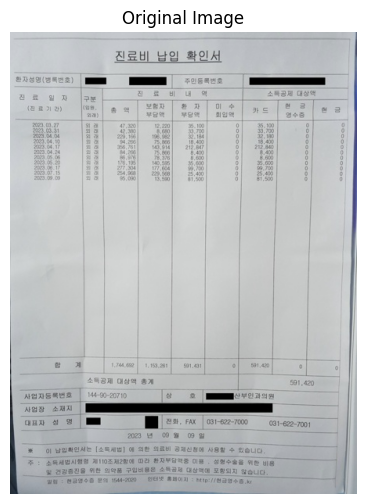

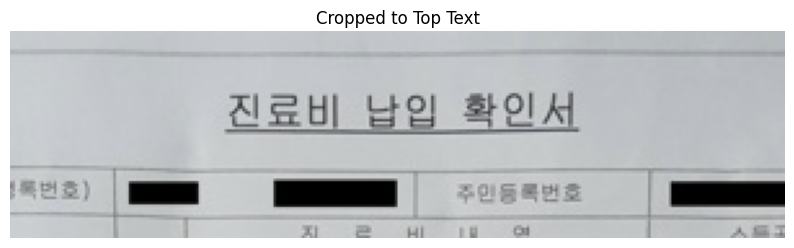

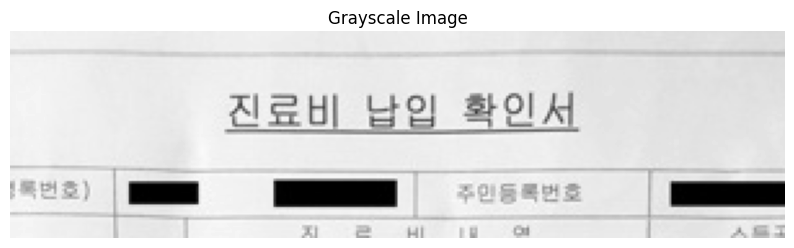

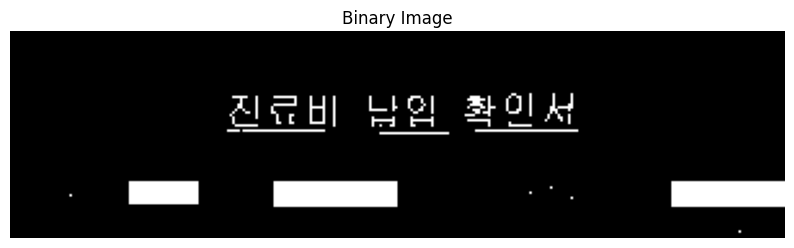

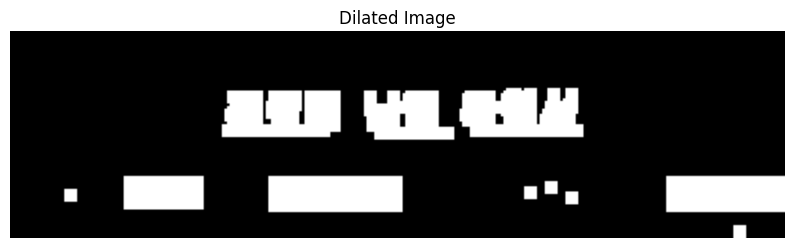

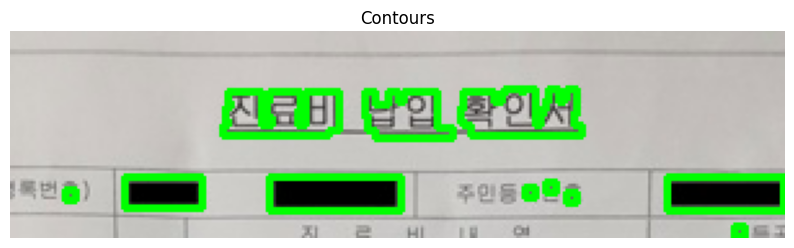

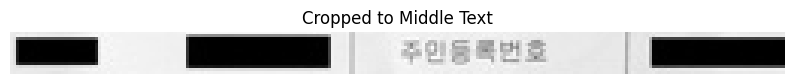

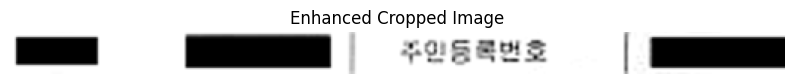


진료비납입확인서||--겨~
                     ID             OCR  target
0  1a7b8a8cfc41b2b2.jpg  진료비납입확인서||--겨~      10


In [402]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import pytesseract
import re
import pandas as pd

# Function to display image using matplotlib
def show_image(img, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = '/data/ephemeral/home/datasets_fin/ocr_test/1a7b8a8cfc41b2b2.jpg'
img = Image.open(image_path)
show_image(img, "Original Image")

# Assuming you have determined these coordinates:
# (left, top, right, bottom)
crop_area = (50, 0, 350, 80)  # Adjust this to your image

# Crop the image to focus on the top large text area
img_cropped = img.crop(crop_area)
show_image(img_cropped, "Cropped to Top Text")

# Convert the cropped image to a format suitable for OpenCV
img_cropped_cv = np.array(img_cropped)
img_cropped_cv = cv2.cvtColor(img_cropped_cv, cv2.COLOR_RGB2BGR)

# Convert the cropped image to grayscale
gray = cv2.cvtColor(img_cropped_cv, cv2.COLOR_BGR2GRAY)
show_image(gray, "Grayscale Image")

# Apply binary thresholding
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
binary = cv2.bitwise_not(binary)  # Invert the image to make text white and background black
show_image(binary, "Binary Image")

# Apply dilation to connect text regions
kernel = np.ones((5, 5), np.uint8)  # Adjusted kernel size for better text connection
dilated = cv2.dilate(binary, kernel, iterations=1)
show_image(dilated, "Dilated Image")

# Find contours
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image for visualization
contour_img = img_cropped_cv.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
show_image(contour_img, "Contours")

# Filter contours based on area and aspect ratio to find significant text blocks
min_contour_area = 100  # Adjust this threshold based on your specific image
filtered_contours = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if cv2.contourArea(cnt) > min_contour_area:
        filtered_contours.append((x, y, w, h))

# Cluster contours by their vertical position
clusters = {}
for x, y, w, h in filtered_contours:
    vertical_position = y // 20  # Adjust this to cluster vertically close contours
    if vertical_position not in clusters:
        clusters[vertical_position] = []
    clusters[vertical_position].append((x, y, w, h))

# Find the largest cluster
largest_cluster = max(clusters.values(), key=lambda cluster: len(cluster))

# Get the bounding box of the largest cluster
x_min = min([x for x, y, w, h in largest_cluster])
y_min = min([y for x, y, w, h in largest_cluster])
x_max = max([x + w for x, y, w, h in largest_cluster])
y_max = max([y + h for x, y, w, h in largest_cluster])

# Crop the ROI from the original image
cropped_img = gray[y_min:y_max, x_min:x_max]
show_image(cropped_img, "Cropped to Middle Text")

# Enhance the cropped image for better OCR accuracy
enhancer = ImageEnhance.Contrast(Image.fromarray(cropped_img))
enhanced_img = enhancer.enhance(2)
enhanced_img = enhanced_img.filter(ImageFilter.SHARPEN)
enhanced_img = enhanced_img.resize((enhanced_img.width * 2, enhanced_img.height * 2), Image.BICUBIC)
show_image(np.array(enhanced_img), "Enhanced Cropped Image")

# Convert the enhanced image back to PIL Image for OCR
roi_pil = enhanced_img

# OCR configurations for Korean text
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(roi_pil, lang='kor', config=custom_config)

text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces into one
text = text.replace(" ", "")  # Remove all spaces in the line
print(text)

# crop 안될 경우 gray로 텍스트변환
text2 = pytesseract.image_to_string(gray, lang='kor', config=custom_config)

text2 = re.sub(r'\s+', ' ', text2).strip()  # Collapse multiple spaces into one
text2 = text2.replace(" ", "")  # Remove all spaces in the line

print(text2)

# Define the keyword lists
keywords_1= ['임신','출산']
keywords_3 = ['퇴원','원확인서']
keywords_4 = ['진단서']
keywords_5= ['운전','면허증']
keywords_6 = ['외래', '계산서']
keywords_7 = ['통원']
keywords_8= ['주민등록증']
keywords_9= ['대한민국','여권']
keywords_10 = ['납입']
keywords_11= ['영수증','복약','조제']
keywords_12= ['처방전']
keywords_13= ['이력서','자소서']
keywords_14 = ['소견서']
keywords_15= ['자동차등록증']



# Combine all keywords into a dictionary with their corresponding numbers
keywords_dict = {
    1: keywords_1,
    3: keywords_3,
    4: keywords_4,
    5: keywords_5,
    6: keywords_6,
    7: keywords_7,
    8: keywords_8,
    9: keywords_9,
    10: keywords_10,
    11: keywords_11,
    12: keywords_12,
    13: keywords_13,
    14: keywords_14,
    15: keywords_15,
}


# Initialize an empty list to store the results
results = []

# Iterate over the keywords dictionary and check if any keyword is in the text

for number, keywords in keywords_dict.items(): 
    if any(keyword in text for keyword in keywords):
        results.append((os.path.basename(image_path), text, number))
    elif any(keyword in text2 for keyword in keywords):
        results.append((os.path.basename(image_path), text2, number))

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['ID', 'OCR', 'target'])

# Display the DataFrame
print(df)


In [389]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import pytesseract
import re
import pandas as pd

# Function to display image using matplotlib
def show_image(img, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_image_turn(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure the image is in RGB format
    img = np.array(img)  # Convert the PIL image to a NumPy array

    ##################### rotate
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Find lines using HoughLines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is None:
        return Image.fromarray(img), Image.fromarray(img), Image.fromarray(img), Image.fromarray(img)

    # Calculate the angle of the skew
    angles = []
    for line in lines:
        rho, theta = line[0]
        angle = np.degrees(theta) - 90
        angles.append(angle)

    # Compute the median angle
    median_angle = np.median(angles)
    print(f"Median angle: {median_angle}")

    # Rotate the image to correct the skew
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Convert back to PIL image to display
    rotated_pil = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    
    # Horizontally flip the rotated image
    mirrored_pil1 = ImageOps.mirror(rotated_pil)
    
    # Flip the rotated image vertically
    flipped_pil = ImageOps.flip(rotated_pil)
    
    # Horizontally flip the rotated image
    mirrored_pil2 = ImageOps.mirror(flipped_pil)

    return rotated_pil, mirrored_pil1, flipped_pil, mirrored_pil2

# Function to process an image with OCR
def process_image_with_ocr(img, image_name):
    if img is None:
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    # Crop the image to focus on the top large text area
    crop_area = (50, 0, 350, 80)  # Adjust this to your image
    img_cropped = img.crop(crop_area)

    # Convert the cropped image to a format suitable for OpenCV
    img_cropped_cv = np.array(img_cropped)
    img_cropped_cv = cv2.cvtColor(img_cropped_cv, cv2.COLOR_RGB2BGR)

    # Convert the cropped image to grayscale
    gray = cv2.cvtColor(img_cropped_cv, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary = cv2.bitwise_not(binary)  # Invert the image to make text white and background black

    # Apply dilation to connect text regions
    kernel = np.ones((5, 5), np.uint8)  # Adjusted kernel size for better text connection
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and aspect ratio to find significant text blocks
    min_contour_area = 100  # Adjust this threshold based on your specific image
    filtered_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if cv2.contourArea(cnt) > min_contour_area:
            filtered_contours.append((x, y, w, h))

    # Cluster contours by their vertical position
    clusters = {}
    for x, y, w, h in filtered_contours:
        vertical_position = y // 20  # Adjust this to cluster vertically close contours
        if vertical_position not in clusters:
            clusters[vertical_position] = []
        clusters[vertical_position].append((x, y, w, h))

    if not clusters:
        # If no clusters are found, return an empty DataFrame
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    # Find the largest cluster
    largest_cluster = max(clusters.values(), key=lambda cluster: len(cluster))

    # Get the bounding box of the largest cluster
    x_min = min([x for x, y, w, h in largest_cluster])
    y_min = min([y for x, y, w, h in largest_cluster])
    x_max = max([x + w for x, y, w, h in largest_cluster])
    y_max = max([y + h for x, y, w, h in largest_cluster])

    # Crop the ROI from the original image
    cropped_img = gray[y_min:y_max, x_min:x_max]

    # Enhance the cropped image for better OCR accuracy
    enhancer = ImageEnhance.Contrast(Image.fromarray(cropped_img))
    enhanced_img = enhancer.enhance(2)
    enhanced_img = enhanced_img.filter(ImageFilter.SHARPEN)
    enhanced_img = enhanced_img.resize((enhanced_img.width * 2, enhanced_img.height * 2), Image.BICUBIC)

    # Convert the enhanced image back to PIL Image for OCR
    roi_pil = enhanced_img

    # OCR configurations for Korean text
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(roi_pil, lang='kor', config=custom_config)
    text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces into one
    text = text.replace(" ", "")  # Remove all spaces in the line
    
    text2 = pytesseract.image_to_string(gray, lang='kor', config=custom_config)
    text2 = re.sub(r'\s+', ' ', text2).strip()  # Collapse multiple spaces into one
    text2 = text2.replace(" ", "")  # Remove all spaces in the line

# Define the keyword lists
    keywords_1= ['임신','출산']
    keywords_3 = ['퇴원','원확인서']
    keywords_4 = ['진단서']
    keywords_5= ['운전','면허증']
    keywords_6 = ['외래', '계산서']
    keywords_7 = ['통원']
    keywords_8= ['주민등록증']
    keywords_9= ['대한민국','여권']
    keywords_10 = ['납입']
    keywords_11= ['영수증','복약','조제']
    keywords_12= ['처방전']
    keywords_13= ['이력서','자소서']
    keywords_14 = ['소견서']
    keywords_15= ['자동차등록증']
    
    

    # Combine all keywords into a dictionary with their corresponding numbers
    keywords_dict = {
        1: keywords_1,
        3: keywords_3,
        4: keywords_4,
        5: keywords_5,
        6: keywords_6,
        7: keywords_7,
        8: keywords_8,
        9: keywords_9,
        10: keywords_10,
        11: keywords_11,
        12: keywords_12,
        13: keywords_13,
        14: keywords_14,
        15: keywords_15,
    }

    # Initialize an empty list to store the results
    results = []

    # Iterate over the keywords dictionary and check if any keyword is in the text
    for number, keywords in keywords_dict.items(): 
        if any(keyword in text for keyword in keywords):
            results.append((image_name, text, number))
        elif any(keyword in text2 for keyword in keywords):
            results.append((image_name, text2, number))


    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['ID', 'OCR', 'target'])

    return df

# Function to process all images in a directory
def process_directory(directory):
    all_results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                rotated_pil, mirrored_pil1, flipped_pil, mirrored_pil2 = process_image_turn(image_path)
                if rotated_pil:
                    df = process_image_with_ocr(rotated_pil, file)
                    if not df.empty:
                        all_results.append(df)
                if mirrored_pil1:
                    df = process_image_with_ocr(mirrored_pil1, file)
                    if not df.empty:
                        all_results.append(df)    
                if flipped_pil:
                    df = process_image_with_ocr(flipped_pil, file)
                    if not df.empty:
                        all_results.append(df)    
                if mirrored_pil2:
                    df = process_image_with_ocr(mirrored_pil2, file)
                    if not df.empty:
                        all_results.append(df)                          
                    
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        final_df = pd.DataFrame(columns=['ID', 'OCR', 'target'])
    return final_df

# Directory containing the images
directory = '/data/ephemeral/home/datasets_fin/test'

# Process all images in the directory
result_df = process_directory(directory)

# Save the result to a CSV file
result_df.to_csv(r'/data/ephemeral/home/notebook/ocr_df.csv', index=False)

# Display the final result DataFrame
print("Final Result DataFrame:")
print(result_df)


Median angle: 0.0
Median angle: 31.99999237060547
Median angle: -30.000003814697266
Median angle: 71.0
Median angle: 6.0
Median angle: 0.9999923706054688
Median angle: 28.99999237060547
Median angle: -90.0
Median angle: 88.0
Median angle: 31.99999237060547
Median angle: 0.0
Median angle: 39.9999885559082
Median angle: -89.00000005960464
Median angle: 0.0
Median angle: 1.9999923706054688
Median angle: 10.999992370605469
Median angle: 83.99998474121094
Median angle: -90.0
Median angle: 74.99998474121094
Median angle: -29.0
Median angle: -89.00000005960464
Median angle: 0.0
Median angle: -44.50000002980232
Median angle: -90.0
Median angle: 45.99999237060547
Median angle: -38.000004053115845
Median angle: 87.49999237060547
Median angle: 79.99998474121094
Median angle: -89.00000005960464
Median angle: -27.000003814697266
Median angle: -90.0
Median angle: 76.99998474121094
Median angle: 42.999996185302734
Median angle: -45.0
Median angle: -30.500003814697266
Median angle: 6.0
Median angle: 7

# ocr_test

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import pytesseract
import re
import pandas as pd

# Function to display image using matplotlib
def show_image(img, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def process_image_turn(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure the image is in RGB format
    img = np.array(img)  # Convert the PIL image to a NumPy array

    ##################### rotate
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Find lines using HoughLines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    if lines is None:
        return Image.fromarray(img), Image.fromarray(img), Image.fromarray(img), Image.fromarray(img)

    # Calculate the angle of the skew
    angles = []
    for line in lines:
        rho, theta = line[0]
        angle = np.degrees(theta) - 90
        angles.append(angle)

    # Compute the median angle
    median_angle = np.median(angles)
    # print(f"Median angle: {median_angle}")

    # Rotate the image to correct the skew
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Convert back to PIL image to display
    rotated_pil = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    
    # Horizontally flip the rotated image
    mirrored_pil1 = ImageOps.mirror(rotated_pil)
    
    # Flip the rotated image vertically
    flipped_pil = ImageOps.flip(rotated_pil)
    
    # Horizontally flip the rotated image
    mirrored_pil2 = ImageOps.mirror(flipped_pil)

    return rotated_pil, mirrored_pil1, flipped_pil, mirrored_pil2

# Function to process an image with OCR
def process_image_with_ocr(img, image_name):
    if img is None:
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    # Crop the image to focus on the top large text area
    crop_area = (50, 0, 350, 80)  # Adjust this to your image
    img_cropped = img.crop(crop_area)

    # Convert the cropped image to a format suitable for OpenCV
    img_cropped_cv = np.array(img_cropped)
    img_cropped_cv = cv2.cvtColor(img_cropped_cv, cv2.COLOR_RGB2BGR)

    # Convert the cropped image to grayscale
    gray = cv2.cvtColor(img_cropped_cv, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary = cv2.bitwise_not(binary)  # Invert the image to make text white and background black

    # Apply dilation to connect text regions
    kernel = np.ones((5, 5), np.uint8)  # Adjusted kernel size for better text connection
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and aspect ratio to find significant text blocks
    min_contour_area = 100  # Adjust this threshold based on your specific image
    filtered_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if cv2.contourArea(cnt) > min_contour_area:
            filtered_contours.append((x, y, w, h))

    # Cluster contours by their vertical position
    clusters = {}
    for x, y, w, h in filtered_contours:
        vertical_position = y // 20  # Adjust this to cluster vertically close contours
        if vertical_position not in clusters:
            clusters[vertical_position] = []
        clusters[vertical_position].append((x, y, w, h))

    if not clusters:
        # If no clusters are found, return an empty DataFrame
        return pd.DataFrame(columns=['ID', 'OCR', 'target'])

    # Find the largest cluster
    largest_cluster = max(clusters.values(), key=lambda cluster: len(cluster))

    # Get the bounding box of the largest cluster
    x_min = min([x for x, y, w, h in largest_cluster])
    y_min = min([y for x, y, w, h in largest_cluster])
    x_max = max([x + w for x, y, w, h in largest_cluster])
    y_max = max([y + h for x, y, w, h in largest_cluster])

    # Crop the ROI from the original image
    cropped_img = gray[y_min:y_max, x_min:x_max]

    # Enhance the cropped image for better OCR accuracy
    enhancer = ImageEnhance.Contrast(Image.fromarray(cropped_img))
    enhanced_img = enhancer.enhance(2)
    enhanced_img = enhanced_img.filter(ImageFilter.SHARPEN)
    enhanced_img = enhanced_img.resize((enhanced_img.width * 2, enhanced_img.height * 2), Image.BICUBIC)

    # Convert the enhanced image back to PIL Image for OCR
    roi_pil = enhanced_img

    # OCR configurations for Korean text
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(roi_pil, lang='kor', config=custom_config)
    text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces into one
    text = text.replace(" ", "")  # Remove all spaces in the line
    
    text2 = pytesseract.image_to_string(gray, lang='kor', config=custom_config)
    text2 = re.sub(r'\s+', ' ', text2).strip()  # Collapse multiple spaces into one
    text2 = text2.replace(" ", "")  # Remove all spaces in the line


# Define the keyword lists
    keywords_1= ['임신','출산']
    keywords_3 = ['퇴원','원확인서']
    keywords_4 = ['진단서']
    keywords_5= ['운전','면허증']
    keywords_6 = ['외래', '계산서']
    keywords_7 = ['통원']
    keywords_8= ['주민등록증']
    keywords_9= ['대한민국','여권']
    keywords_10 = ['납입']
    keywords_11= ['영수증','복약','조제']
    keywords_12= ['처방전']
    keywords_13= ['이력서','자소서']
    keywords_14 = ['소견서']
    keywords_15= ['자동차등록증']
    
    

    # Combine all keywords into a dictionary with their corresponding numbers
    keywords_dict = {
        1: keywords_1,
        3: keywords_3,
        4: keywords_4,
        5: keywords_5,
        6: keywords_6,
        7: keywords_7,
        8: keywords_8,
        9: keywords_9,
        10: keywords_10,
        11: keywords_11,
        12: keywords_12,
        13: keywords_13,
        14: keywords_14,
        15: keywords_15,
    }

    # Initialize an empty list to store the results
    results = []

    # Iterate over the keywords dictionary and check if any keyword is in the text
    for number, keywords in keywords_dict.items(): 
        if any(keyword in text for keyword in keywords):
            results.append((image_name, text, number))
        elif any(keyword in text2 for keyword in keywords):
            results.append((image_name, text2, number))


    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=['ID', 'OCR', 'target'])

    return df

# Function to process all images in a directory
def process_directory(directory):
    all_results = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                rotated_pil, mirrored_pil1, flipped_pil, mirrored_pil2 = process_image_turn(image_path)
                print("***********",image_path)
                if rotated_pil:
                    show_image(rotated_pil)
                    df = process_image_with_ocr(rotated_pil, file)
                    if not df.empty:
                        print("rotated_pil",df)
                        all_results.append(df)
                if mirrored_pil1:
                    show_image(mirrored_pil1)
                    df = process_image_with_ocr(mirrored_pil1, file)                   
                    if not df.empty:
                        print("mirrored_pil1",df)
                        all_results.append(df)    
                if flipped_pil:
                    show_image(flipped_pil)
                    df = process_image_with_ocr(flipped_pil, file)
                    if not df.empty:
                        print("flipped_pil",df)
                        all_results.append(df)    
                if mirrored_pil2:
                    show_image(mirrored_pil2)
                    df = process_image_with_ocr(mirrored_pil2, file)
                    if not df.empty:
                        print("mirrored_pil2",df)
                        all_results.append(df)                          
                    
    if all_results:
        final_df = pd.concat(all_results, ignore_index=True)
    else:
        final_df = pd.DataFrame(columns=['ID', 'OCR', 'target'])
    return final_df

# Directory containing the images
directory = '/data/ephemeral/home/datasets_fin/ocr_test'

# Process all images in the directory
result_df = process_directory(directory)

# Save the result to a CSV file
#result_df.to_csv(r'/data/ephemeral/home/notebook/ocr_df.csv', index=False)

# Display the final result DataFrame
print("Final Result DataFrame:")
print(result_df)


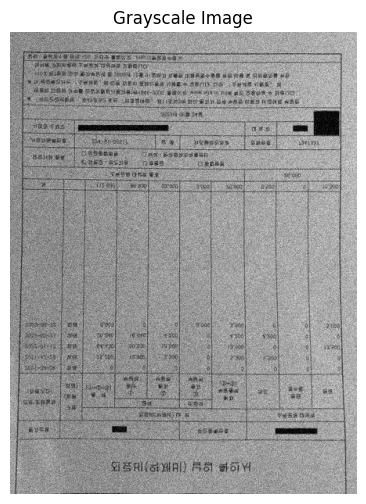

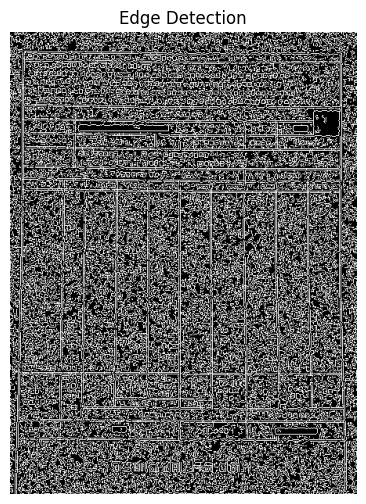

Median angle: 0.0


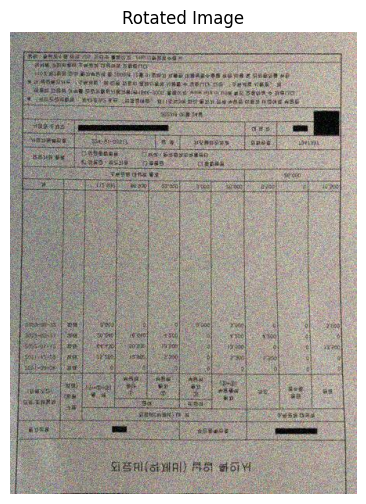

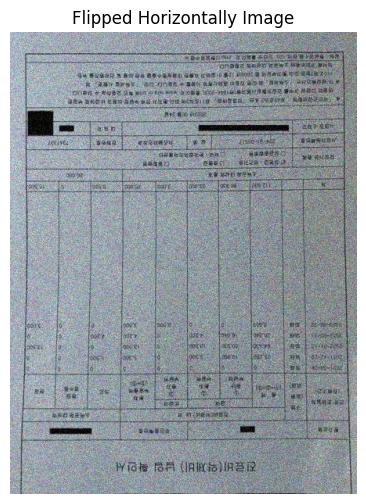

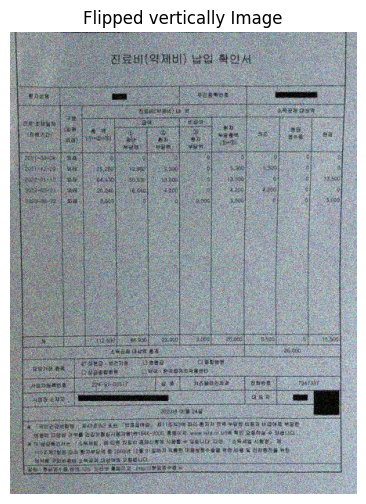

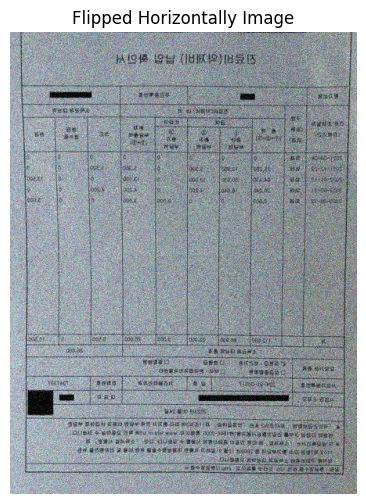

In [395]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pytesseract

# Function to display image using matplotlib
def show_image(img, title="Image", cmap='gray'):
    plt.figure(figsize=(10, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
img_path = '/data/ephemeral/home/datasets_fin/ocr_test/0a26fc63987e05eb_3_9.jpg'
# /data/ephemeral/home/datasets_fin/test/fb65504f89749e15.jpg
# /data/ephemeral/home/datasets_fin/test/ff31c0f0fdc21455.jpg
# /data/ephemeral/home/datasets_fin/test/fb9924486af9b168.jpg
# /data/ephemeral/home/datasets_fin/ocr_test/0a26fc63987e05eb_3_9.jpg
img = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray, "Grayscale Image")

# Apply edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
show_image(edges, "Edge Detection")

# Find lines using HoughLines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# Calculate the angle of the skew
angles = []
for line in lines:
    rho, theta = line[0]
    angle = np.degrees(theta) - 90
    angles.append(angle)

# Compute the median angle
median_angle = np.median(angles)
print(f"Median angle: {median_angle}")

# Rotate the image to correct the skew
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, median_angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# Convert back to PIL image to display
rotated_pil = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
show_image(rotated, "Rotated Image", cmap='gray')

# Horizontally flip the image
flipped_img1 = ImageOps.mirror(rotated_pil)
show_image(flipped_img1, "Flipped Horizontally Image", cmap='gray')

# Flip the rotated image vertically
flipped_pil = ImageOps.flip(rotated_pil)
show_image(flipped_pil, "Flipped vertically Image", cmap='gray')

# Horizontally flip the image
flipped_img2 = ImageOps.mirror(flipped_pil)
show_image(flipped_img2, "Flipped Horizontally Image", cmap='gray')

In [356]:
# baseline
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
      log += f"{k}: {v:.4f}\n"
    print(log)
    
    # WandB에 로그 기록
    wandb.log({
        "epoch": epoch,
        "train_loss": ret["train_loss"],
        "train_acc": ret["train_acc"],
        "train_f1": ret["train_f1"]
    })
    
# 실험 종료
wandb.finish()

Loss: 0.3256: 100%|██████████| 982/982 [00:56<00:00, 17.27it/s]


train_loss: 0.3415
train_acc: 0.8880
train_f1: 0.8815
epoch: 0.0000



Loss: 0.0011: 100%|██████████| 982/982 [00:55<00:00, 17.57it/s]


train_loss: 0.1322
train_acc: 0.9568
train_f1: 0.9549
epoch: 1.0000



Loss: 0.1707: 100%|██████████| 982/982 [00:55<00:00, 17.59it/s]


train_loss: 0.0962
train_acc: 0.9687
train_f1: 0.9672
epoch: 2.0000



Loss: 0.0098: 100%|██████████| 982/982 [00:55<00:00, 17.58it/s]


train_loss: 0.0792
train_acc: 0.9727
train_f1: 0.9708
epoch: 3.0000



Loss: 0.0001: 100%|██████████| 982/982 [00:55<00:00, 17.54it/s]


train_loss: 0.0618
train_acc: 0.9801
train_f1: 0.9790
epoch: 4.0000



Loss: 0.0019: 100%|██████████| 982/982 [00:56<00:00, 17.51it/s]


train_loss: 0.0630
train_acc: 0.9792
train_f1: 0.9782
epoch: 5.0000



Loss: 2.1586: 100%|██████████| 982/982 [00:55<00:00, 17.57it/s]


train_loss: 0.0373
train_acc: 0.9890
train_f1: 0.9883
epoch: 6.0000



Loss: 0.0072: 100%|██████████| 982/982 [00:56<00:00, 17.53it/s]


train_loss: 0.0458
train_acc: 0.9853
train_f1: 0.9845
epoch: 7.0000



Loss: 0.0015: 100%|██████████| 982/982 [00:55<00:00, 17.66it/s]


train_loss: 0.0418
train_acc: 0.9862
train_f1: 0.9852
epoch: 8.0000



Loss: 0.0040: 100%|██████████| 982/982 [00:55<00:00, 17.67it/s]


train_loss: 0.0257
train_acc: 0.9923
train_f1: 0.9919
epoch: 9.0000



epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇████
train_f1,▁▆▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
epoch,9
train_acc,0.99229
train_f1,0.99194
train_loss,0.02566


In [84]:
import timm
print(timm.list_models(pretrained=True))


['bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'beitv2_large_patch16_224.in1k_ft_in22k', 'beitv2_large_patch16_224.in1k_ft_in22k_in1k', 'botnet26t_256.c1_in1k', 'caformer_b36.sail_in1k', 'caformer_b36.sail_in1k_384', 'caformer_b36.sail_in22k', 'caformer_b36.sail_in22k_ft_in1k', 'caformer_b36.sail_in22k_ft_in1k_384', 'caformer_m36.sail_in1k', 'caformer_m36.sail_in1k_384', 'caformer_m36.sail_in22k', 'caformer_m36.sail_in22k_ft_in1k', 'caformer_m36.sail_in22k_ft_in1k_384', 'caformer_s18.sail_in1k', 'caformer_s18.sail_in1k_384', 'caformer_s

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [357]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 197/197 [00:14<00:00, 13.19it/s]


In [358]:
preds.shape

torch.Size([4, 17])

In [359]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [360]:
sample_submission_df = pd.read_csv("/data/ephemeral/home/datasets_fin/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [361]:
pred_df.to_csv("pred_0802_09:20.csv", index=False)

In [362]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,13
4,00901f504008d884.jpg,2


In [396]:
# 최종 ocr과 합치기 : 문제점: ocr에 중복데이터가 존재함, 일단 가장 마지막 target값을 사용


import pandas as pd

# 데이터 불러오기
pred_df = pd.read_csv("/data/ephemeral/home/notebook/output.csv")
ocr_df = pd.read_csv("/data/ephemeral/home/notebook/ocr_df.csv")

# 중복된 ID 제거 (먼저 가장 마지막 target 값을 사용하는 예시입니다.)
ocr_df = ocr_df.drop_duplicates(subset='ID', keep='last')

# 병합 (merge)
merged_df = pred_df.merge(ocr_df[['ID', 'target']], on='ID', how='left', suffixes=('', '_ocr'))

# # target 값 대체 (replace)
merged_df['target'] = merged_df['target_ocr'].combine_first(merged_df['target'])

# # 필요 없는 'target_ocr' 컬럼 삭제
merged_df = merged_df.drop(columns=['target_ocr'])

# # 결과 저장
merged_df.to_csv("/data/ephemeral/home/notebook/pred_ocr_0802_03.csv", index=False)

print("Successfully saved the merged DataFrame.")


# print("Successfully saved the merged DataFrame.")
print(len(pred_df), len(ocr_df), len(merged_df))


Successfully saved the merged DataFrame.
3140 275 3140


In [382]:
merged_df

,ID,target
0,0008fdb22ddce0ce.jpg,2.0
1,00091bffdffd83de.jpg,12.0
2,00396fbc1f6cc21d.jpg,5.0
3,00471f8038d9c4b6.jpg,13.0
4,00901f504008d884.jpg,2.0
...,...,...
3135,ffb4b6f619fb60ea.jpg,6.0
3136,ffb54299b1ad4159.jpg,6.0
3137,ffc2c91dff8cf2c0.jpg,8.0
3138,ffc4e330a5353a2a.jpg,0.0
